In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.spatial.transform import Rotation
from sklearn.manifold import TSNE

np.random.seed(42)


## Autoencoder for dimensionality reduction

In [10]:
def plot_2d_data(X):
  fig = plt.figure(figsize=(4,3))
  plt.plot(X[:,0], X[:, 1], "b.")
  plt.xlabel("$z_1$", fontsize=18)
  plt.ylabel("$z_2$", fontsize=18, rotation=0)
  plt.grid(True)
  plt.show()  

In [13]:
# Generate random data

# Generating a 3D dataset that the autoencoder will reduce to a 2D dataset

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset

angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X_train = X + [0.2, 0, 0.2]  # shift a bit


In [14]:
# Only linear activation functions makes this autoencoder equivalent to PCA

# The encoder units are the hidden layer which is 2D
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])

# The decoder units are the output which is 3D and is equal to the input data
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])

# Even though this is a linear model, we separate the encoder from the decoder so that we can 
# get the latent representation (the lower dimensional one)
autoencoder = tf.keras.Sequential([encoder, decoder])

optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.5)
autoencoder.compile(loss="mse", optimizer=optimizer)

# Note that the targets are actually the inputs
autoencoder.fit(X_train, X_train, epochs=500, verbose=False)
codings = encoder.predict(X_train)


2/2 [==============================] - 0s 1ms/step


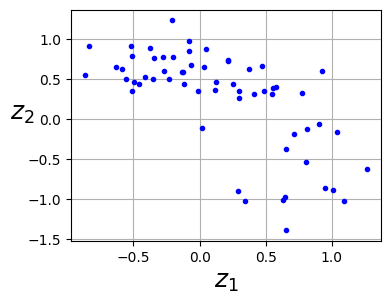

In [16]:
plot_2d_data(codings)

In [21]:
# The final representation of the autoencoder is very similar to the input

codings_3d = autoencoder.predict(X_train)
print (np.sum(codings_3d))
print (np.sum(X_train))

2/2 [==============================] - 0s 958us/step
-15.49791
-15.756680631509237


## Stacked Autoencoders 

Can be used when the data is of higher dimensional and requires a more complex model to capture its semantics.

We'll be using the fashion MNIST dataset

In [22]:
# Loading fashion MNIST

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [24]:
# Building the stacked autoencoder

# We split the sequential models into two submodules: encoder and decoder.

stacked_encoder = tf.keras.Sequential([
  # Flatten the (28,28) images to a 784 vector
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
])

stacked_decoder =  tf.keras.Sequential([
  tf.keras.layers.Dense(100, activation="relu"),
  tf.keras.layers.Dense(28 * 28),
  # Reshape back to (28,28) so that the decoder has the same output shape as the encoder's input
  tf.keras.layers.Reshape([28, 28])
])

stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])

optimizer = tf.keras.optimizers.legacy.Nadam()
stacked_ae.compile(loss="mse", optimizer=optimizer)

history = stacked_ae.fit(X_train, X_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.0244


1/1 [==============================] - 0s 48ms/step


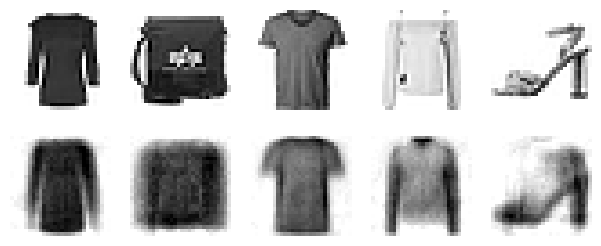

In [25]:
# Visualizing the reconstructions

# We'll use the validation set for this task.

# Seeing the reconstructions vs the original images side by side
def plot_reconstructions(model, images=X_valid, n_images=5):
  # Clip output values between 0 and 1
  reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)

  fig = plt.figure(figsize=(n_images * 1.5, 3))

  for image_index in range(n_images):
    plt.subplot(2, n_images, 1 + image_index)
    plt.imshow(images[image_index], cmap="binary")
    plt.axis("off")
    
    plt.subplot(2, n_images, 1 + n_images + image_index)
    plt.imshow(reconstructions[image_index], cmap="binary")
    plt.axis("off")

plot_reconstructions(stacked_ae)


In [28]:
# Using autoencoders followed by TNSE for dimensionality reduction

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)

157/157 [==============================] - 0s 380us/step


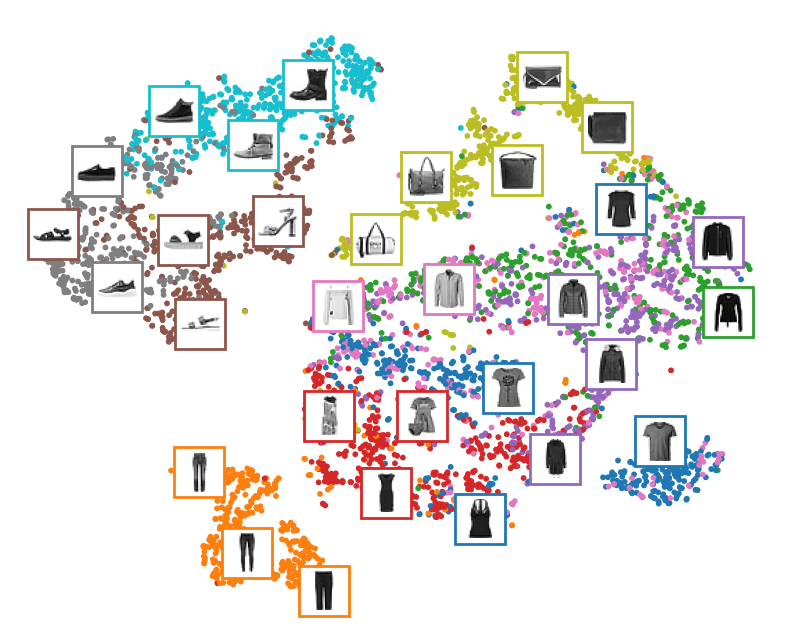

In [33]:
# Plot the reduced images

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10

Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range

plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)

# Positions of images that will get displayed
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    # Compute the distance between the current image position to other ones that are displayed
    dist = ((position - image_positions) ** 2).sum(axis=1)

    # if far enough from other images
    if dist.min() > 0.015: 
        # Add the current image's position as displayed
        image_positions = np.r_[image_positions, [position]]

        # Display the image on the plot
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()

## Convolusional Autoencoders


In [34]:
conv_encoder = tf.keras.Sequential([
  tf.keras.layers.Reshape([28, 28, 1]),
  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  # output: 14 x 14 x 16
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  # output: 7 x 7 x 32
  tf.keras.layers.MaxPool2D(pool_size=2),
  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  # output: 3 x 3 x 64
  tf.keras.layers.Conv2D(30, 3, padding="same", activation="relu"),
  # output: 30
  tf.keras.layers.GlobalAvgPool2D()
])

conv_decoder = tf.keras.Sequential([
  tf.keras.layers.Dense(3 * 3 * 16),
  tf.keras.layers.Reshape((3, 3, 16)),
  tf.keras.layers.Conv2DTranspose(32, 3, strides=2, activation="relu"),
  tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding="same", 
                                  activation="relu"),
  tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding="same"),
  tf.keras.layers.Reshape((28, 28))
])

conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

In [35]:
conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 7ms/step - loss: 0.0356 - val_loss: 0.0246
Epoch 2/10
1432/1719 [=======================>......] - ETA: 2s - loss: 0.0228